# Part 2: Regression

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)

In [2]:
data = pd.read_pickle('data.pkl')

In [3]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    #'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [4]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
from sklearn.decomposition import PCA

lagpart=['item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag']

X_train_lagpart=X_train[lagpart]
X_valid_lagpart=X_valid[lagpart]
X_test_lagpart=X_test[lagpart]


pca = PCA(n_components=X_train_lagpart.shape[1])#n_components=X_train.shape[1]
pca.fit(X_train_lagpart)
print(pca.explained_variance_ratio_)

[4.59871339e-01 1.40540865e-01 1.00037322e-01 8.61769977e-02
 5.33348845e-02 4.92750204e-02 2.32227818e-02 1.86974900e-02
 1.45294925e-02 1.24995475e-02 1.12814234e-02 9.20011087e-03
 7.71124662e-03 3.31857603e-03 3.16672920e-03 2.49521914e-03
 1.71051315e-03 1.16162742e-03 9.22231864e-04 4.51565255e-04
 3.95016161e-04]


In [6]:
X_train_lagpart=pca.transform(X_train_lagpart)
X_valid_lagpart=pca.transform(X_valid_lagpart)
X_test_lagpart=pca.transform(X_test_lagpart)


cols=[]
for i in range(len(lagpart)):
    cols.append('F_'+str(i))
    X_train['F_'+str(i)]=X_train_lagpart[:,i].astype(np.float16)
    X_valid['F_'+str(i)]=X_valid_lagpart[:,i].astype(np.float16)
    X_test['F_'+str(i)]=X_test_lagpart[:,i].astype(np.float16)
    
X_train.drop(lagpart, axis=1, inplace=True)
X_valid.drop(lagpart, axis=1, inplace=True)
X_test.drop(lagpart, axis=1, inplace=True)

X_train.info()

C:\Users\bijiachuan\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6186922 entries, 4488710 to 10675631
Data columns (total 33 columns):
date_block_num          int8
shop_id                 int8
item_id                 int16
city_code               int8
item_category_id        int8
type_code               int8
subtype_code            int8
month                   int8
days                    int8
item_last_sale          int8
item_shop_first_sale    int8
item_first_sale         int8
F_0                     float16
F_1                     float16
F_2                     float16
F_3                     float16
F_4                     float16
F_5                     float16
F_6                     float16
F_7                     float16
F_8                     float16
F_9                     float16
F_10                    float16
F_11                    float16
F_12                    float16
F_13                    float16
F_14                    float16
F_15                    float16
F_16               

In [7]:
del data
del X_train_lagpart
del X_test_lagpart
del X_valid_lagpart
gc.collect();

In [8]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse",     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.15657	validation_1-rmse:1.12011
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11417	validation_1-rmse:1.08439
[2]	validation_0-rmse:1.07757	validation_1-rmse:1.05591
[3]	validation_0-rmse:1.04713	validation_1-rmse:1.03205
[4]	validation_0-rmse:1.02404	validation_1-rmse:1.01528
[5]	validation_0-rmse:1.00109	validation_1-rmse:0.998344
[6]	validation_0-rmse:0.982005	validation_1-rmse:0.984622
[7]	validation_0-rmse:0.967921	validation_1-rmse:0.975599
[8]	validation_0-rmse:0.953414	validation_1-rmse:0.965759
[9]	validation_0-rmse:0.941042	validation_1-rmse:0.957025
[10]	validation_0-rmse:0.930709	validation_1-rmse:0.950606
[11]	validation_0-rmse:0.922103	validation_1-rmse:0.945443
[12]	validation_0-rmse:0.914407	validation_1-rmse:0.940815
[13]	validation_0-rmse:0.907801	validation_1-rmse:0.937237
[14]	validation_0-rmse:0.902023	vali

1975.543487071991

In [9]:
test  = pd.read_csv('input/test.csv').set_index('ID')

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_new1.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle_new1', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle_new1', 'wb'))

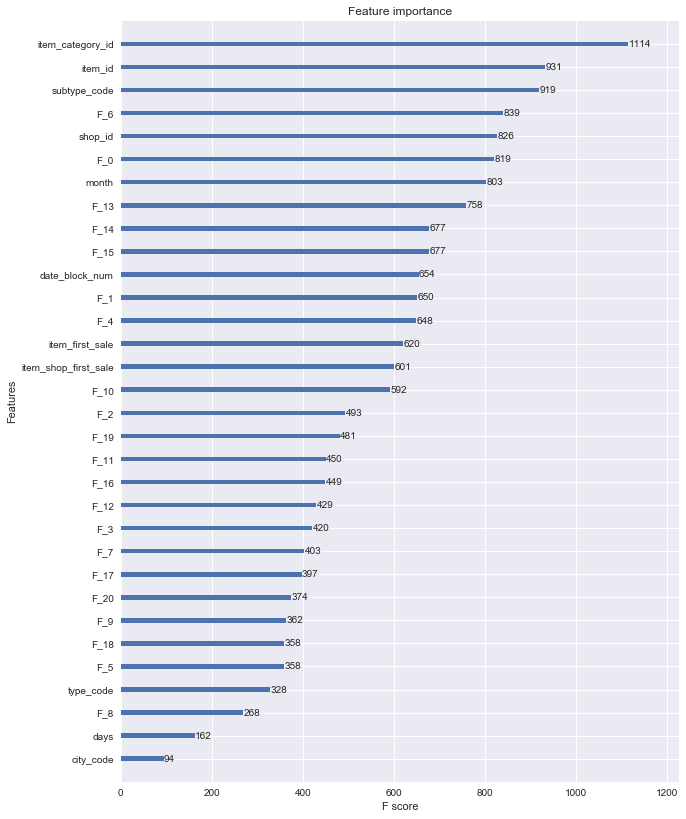

In [10]:
plot_features(model, (10,14))

In [11]:
del X_train
del Y_train
del X_valid
del Y_valid
del X_test
del Y_test
gc.collect()

29

 # End 